In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [2]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph.message import add_messages

# 상태 정의
class State(TypedDict):	
    messages: Annotated[list[str], add_messages]

In [3]:
from langgraph.graph import StateGraph

# 그래프 구성
graph_builder = StateGraph(State)

In [4]:
from langchain_core.tools import tool
from datetime import datetime
import pytz
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

# 도구 함수 정의
@tool
def get_current_time(timezone: str, location: str) -> str:
    """현재 시각을 반환하는 함수."""
    try:
        tz = pytz.timezone(timezone)
        now = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        result = f'{timezone} ({location}) 현재시각 {now}'
        # print(result)
        return result
    except pytz.UnknownTimeZoneError:
        return f"알 수 없는 타임존: {timezone}"
    
@tool
def get_web_search(query: str, search_period: str='m') -> str:
    """
    웹 검색을 수행하는 함수.
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        # region="kr-kr", 
        time=search_period
    )

    print('\n-------- WEB SEARCH --------')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        # source="news",
        results_separator=';\n'
    )

    searched = search.invoke(query)
    
    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')
    
    return searched

# 도구 바인딩
tools = [get_current_time, get_web_search]

In [5]:
tools[0].invoke({"timezone": "Asia/Seoul", "location": "부산"})

'Asia/Seoul (부산) 현재시각 2025-09-27 14:40:49'

In [6]:
query = "2025년 KT 소액결제 사건의 원인은?"

In [7]:
tools[1].invoke({"query": query, "search_period": "m"})


-------- WEB SEARCH --------
2025년 KT 소액결제 사건의 원인은?
m
1. snippet: 2 weeks ago - 왜 KT만 털렸나 무단 소액결제 사건 의문점 3가지 KT는 11일 불법 초소형 기지국을 통해 일부 고객의 국제이동가입자식별정보IMSI 정보가 유출된 것을 확인하고 이를 개인정보보호위원회에 신고했다고 밝혔다., title: Chosun Daily 왜 KT만 털렸나… ‘무단 소액결제’ 사건 의문점 3가지, link: https://www.chosun.com/economy/tech_it/2025/09/11/P6IGLCLDPFFARKYDTBAPSIHFYA/
2. snippet: 2 weeks ago - KT 소액결제 피해 사건의 원인이 ‘ 불법 기지국 ’이라는 정황이 나왔다. 해커들이 불법 기지국 을 설치해 이용자들의 통신 정보를 탈취했을 가능성이 제기된 것으로, 국내에선 발생한 적 없는 사건이다.KT는 지난 8일 ..., title: MediaToday ‘KT 소액결제 사건’ 원인은 불법 기지국? “서버 전수조사해야”, link: https://www.mediatoday.co.kr/news/articleView.html?idxno=328721
3. snippet: 4 days ago - 앞서 방송통신위원회는 소액결제 피해사고 관련 취소나 환불, 피해보상 등을 가장한 악성 불법스팸 문자가 유포될 가능성을 제시하며, 미끼문자를 통해 출처가 불분명한 앱 설치를 유도하는 등 2차 사기 피해에 유의할 것을 ..., title: BBC KT 해킹 피해 일파만파...'무단 소액결제' 어떻게 예방해야 하며, 어떤 조치 취해야? - BBC News 코리아, link: https://www.bbc.com/korean/articles/c20z1l477qqo
4. snippet: 1 week ago - (수원=연합뉴스) 강영훈 기자 = KT 무단 소액결제 사건의 용의자인 중국 국적의 남성들이 경찰에 붙잡혔다., title: Yonhap News

"snippet: 2 weeks ago - 왜 KT만 털렸나 무단 소액결제 사건 의문점 3가지 KT는 11일 불법 초소형 기지국을 통해 일부 고객의 국제이동가입자식별정보IMSI 정보가 유출된 것을 확인하고 이를 개인정보보호위원회에 신고했다고 밝혔다., title: Chosun Daily 왜 KT만 털렸나… ‘무단 소액결제’ 사건 의문점 3가지, link: https://www.chosun.com/economy/tech_it/2025/09/11/P6IGLCLDPFFARKYDTBAPSIHFYA/;\nsnippet: 2 weeks ago - KT 소액결제 피해 사건의 원인이 ‘ 불법 기지국 ’이라는 정황이 나왔다. 해커들이 불법 기지국 을 설치해 이용자들의 통신 정보를 탈취했을 가능성이 제기된 것으로, 국내에선 발생한 적 없는 사건이다.KT는 지난 8일 ..., title: MediaToday ‘KT 소액결제 사건’ 원인은 불법 기지국? “서버 전수조사해야”, link: https://www.mediatoday.co.kr/news/articleView.html?idxno=328721;\nsnippet: 4 days ago - 앞서 방송통신위원회는 소액결제 피해사고 관련 취소나 환불, 피해보상 등을 가장한 악성 불법스팸 문자가 유포될 가능성을 제시하며, 미끼문자를 통해 출처가 불분명한 앱 설치를 유도하는 등 2차 사기 피해에 유의할 것을 ..., title: BBC KT 해킹 피해 일파만파...'무단 소액결제' 어떻게 예방해야 하며, 어떤 조치 취해야? - BBC News 코리아, link: https://www.bbc.com/korean/articles/c20z1l477qqo;\nsnippet: 1 week ago - (수원=연합뉴스) 강영훈 기자 = KT 무단 소액결제 사건의 용의자인 중국 국적의 남성들이 경찰에 붙잡혔다., title: Yonhap News Agency 'KT 소액결제' 사건 40대 중국교포 용의자 2명 검거(종합) | 연합뉴스, link: ht

In [8]:
model_with_tools = model.bind_tools(tools) # GPT 언어모델에 도구 연결

def generate(state: State):
    return {"messages": model_with_tools.invoke(state["messages"])}

graph_builder.add_node("generate", generate)

In [9]:
# import json
# from langchain_core.messages import ToolMessage

# class BasicToolNode:
#     """
#     도구를 실행하는 노드 클래스입니다. 마지막 AIMessage에서 요청된 도구를 실행합니다.
#     """

#     def __init__(self, tools: list) -> None:
#         self.tools_by_name = {tool.name: tool for tool in tools} # 딕셔너리 컴프리헨션(Dictionary Comprehension)

#     def __call__(self, inputs: dict):
#         # inputs에 messages가 있으면 messages를 가져오고 없으면 빈 리스트를 가져옵니다.
#         if messages := inputs.get("messages", []): # 왈러스(walrus) 연산자 사용
#             message = messages[-1]
#         else:
#             raise ValueError("No message found in input")
#         outputs = []
#         for tool_call in message.tool_calls:
#             tool_result = self.tools_by_name[tool_call["name"]].invoke(
#                 tool_call["args"]
#             )
#             outputs.append(
#                 ToolMessage(
#                     content=json.dumps(tool_result),
#                     name=tool_call["name"],
#                     tool_call_id=tool_call["id"],
#                 )
#             )
#         return {"messages": messages + outputs}

In [10]:
# # * Case1
# tool_node = BasicToolNode(tools=tools)
# graph_builder.add_node("tools", tool_node)

In [9]:
# * Case2
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [10]:
from langgraph.graph import START, END

def route_tools(state: State):
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고,
    그렇지 않은 경우 END로 라우팅하기 위해 conditional_edge에서 사용합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_edge 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
        
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [11]:
graph_builder.add_edge(START, "generate")

graph_builder.add_conditional_edges(
    "generate",
    route_tools,
    {"tools": "tools", END: END},
)
# 도구가 호출될 때마다 다음 단계를 결정하기 위해 챗봇으로 돌아갑니다.
graph_builder.add_edge("tools", "generate")

In [12]:
graph = graph_builder.compile()

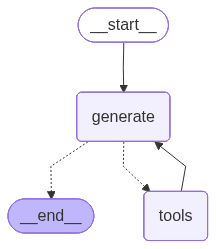

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [13]:
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
         +----------+         
         | generate |         
         +----------+         
          .         *         
        ..           **       
       .               *      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [17]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="'Asia/Seoul' 지금 부산 몇시야?")]

gathered = None

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')

        if gathered is None:
            gathered = msg
        else:
            gathered = gathered + msg

Asia/Seoul (부산) 현재시각 2025-09-27 14:50:50 입니다.

In [18]:
gathered

AIMessageChunk(content='Asia/Seoul (부산) 현재시각 2025-09-27 14:50:50 입니다.', additional_kwargs={'function_call': {'name': 'get_current_time', 'arguments': '{"location": "\\ubd80\\uc0b0", "timezone": "Asia/Seoul"}'}}, response_metadata={'finish_reason': 'STOPSTOP', 'model_name': 'gemini-2.5-flashgemini-2.5-flash', 'safety_ratings': []}, id='run--20650671-204b-4c98-a69e-8f36292bbb4c', tool_calls=[{'name': 'get_current_time', 'args': {'location': '부산', 'timezone': 'Asia/Seoul'}, 'id': 'a53ba5a2-62e5-4089-b914-14cb4beb497e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 321, 'output_tokens': 171, 'total_tokens': 492, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 117}}, tool_call_chunks=[{'name': 'get_current_time', 'args': '{"location": "\\ubd80\\uc0b0", "timezone": "Asia/Seoul"}', 'id': 'a53ba5a2-62e5-4089-b914-14cb4beb497e', 'index': None, 'type': 'tool_call_chunk'}])

In [21]:
from langchain_core.messages import AIMessageChunk, SystemMessage

inputs = [
    SystemMessage(content=f"""
        너는 신문기자이다. 
        최근 {query}에 대해 비판하는 심층 분석 기사를 쓰려고 한다.
    """),
    HumanMessage(content="""
        - 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘. 
        - 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐. 
        - 검색할 리스트를 토대로 재검색을 한다. 
        - 목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해라.
        - 검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋다. 
        
        더 이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성하라.
        제목, 부제, 리드문, 본문 의 구성으로 작성하라. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다.
    """)
]

gathered = None

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        # print(msg.content, end='')

        if gathered is None:
            gathered = msg
        else:
            gathered = gathered + msg


-------- WEB SEARCH --------
2025 KT 소액결제 사건
m
1. snippet: 2025 년 8월 수도권에서 발생한 KT 소액결제 해킹 사건은 불법 초소형 기지국을 통한 역대급 해킹 피해 사례입니다. 피해 현황, 해킹 원인, KT 및 정부 대응, 보상 절차와 예방법까지 한눈에 정리했습니다. 2025 년 8월 말부터 수도권 일부 지역을 중심으로 KT 및 KT 망을 사용하는 알뜰폰 고객들에게 휴대폰 ..., title: Kt 소액결제 해킹 사건 정리 (2025) - 피해 현황·원인·보상 절차 완벽 가이드, link: https://reasonablegift.tistory.com/175
2. snippet: 1. 사건 개요 발생 지역: 경기 광명시 (소하동·하안동)와 서울 금천구 특정 아파트 단지 발생 시기: 2025 년 8월 27일 첫 신고 이후 ~ 9월 6일 피해 규모: 총 74건, 4,580만원 피해 광명경찰서 61건 (3,800만원), 금천경찰서 13건 (780만원) 피해 시간대: 모두 새벽 시간대 발생 피해자 특징: 모두 KT 및 KT 망 알뜰폰 ..., title: Kt 소액결제 해킹 사건 정리 (2025년 9월 기준) : 네이버 블로그, link: https://blog.naver.com/dempsirol4/224000370974
3. snippet: KT 무단 소액결제 사건의 피의자로 중국 국적자 2명이 구속된 가운데 경찰은 이들이 범행을 주도한 것으로 추정되는 '윗선'과 어떻게 공모해 범행에 가담했는지를 집중적으로 수사할 방침이다. 경기남부경찰청 사이버수사과는 19일 정보통신망법 위반 및 컴퓨터 등 사용 사기 혐의로 전날 구속된 중국 ..., title: 'Kt 소액결제' 사건 주범 어디에?…'윗선' 추적에 수사 집중 (종합), link: https://www.yna.co.kr/view/AKR20250919057251061
4. snippet: 1. 개요 [편집] 2025 년 8월부터 수도권 일부 지역에서 KT 와 KT 망

In [22]:
gathered

AIMessageChunk(content="최근 2025년 KT 소액결제 해킹 사건이 발생하여 많은 사람들의 관심이 뜨겁습니다. 특히 불법 초소형 기지국을 이용한 해킹이라는 점에서 충격을 주고 있으며, 통신사의 보안 문제와 개인 정보 보호에 대한 우려가 커지고 있습니다. 이 사건은 단순히 금전적 피해를 넘어 디지털 시대의 보안 취약점을 여실히 보여주는 중요한 사례이므로, 심층 분석 기사 주제로 선정했습니다.\n\n이 사건에 대한 심층 분석 기사를 작성하기 위한 목차와 추가 검색 내용은 다음과 같습니다.\n\n**목차:**\n\n1.  **서론: 2025년 KT 소액결제 해킹 사건, 디지털 시대의 그림자**\n    *   사건 개요 및 발생 배경\n    *   사건의 사회적 파장 및 중요성\n2.  **본론 1: 초소형 기지국 해킹의 실체와 작동 방식**\n    *   초소형 기지국을 활용한 해킹 기술 분석\n    *   어떻게 소액결제가 무단으로 이루어졌는가? (기술적 분석)\n    *   기존 해킹 방식과의 차이점 및 위험성\n3.  **본론 2: KT의 책임과 보안 시스템의 허점**\n    *   KT 통신망 보안 시스템의 취약점 분석\n    *   사건 발생 전후 KT의 대응 및 문제점\n    *   다른 통신사와의 비교를 통한 KT의 보안 수준 진단\n4.  **본론 3: 정부의 역할과 법적, 제도적 미비점**\n    *   정부의 사이버 보안 정책 및 규제 현황\n    *   이번 사건에 대한 정부의 대처 및 한계\n    *   개인 정보 보호 및 피해보상 관련 법규의 실효성\n5.  **결론: 재발 방지를 위한 제언 및 나아가야 할 길**\n    *   통신사의 보안 강화 방안\n    *   정부의 사이버 보안 정책 개선 방향\n    *   이용자들의 경각심 제고 및 예방 수칙\n\n**추가 검색 내용 리스트:**\n\n*   **초소형 기지국 해킹 기술에 대한 상세 정보:**\n    *   초소형 기지국(펨토셀, 스몰셀 

In [23]:
print(gathered.content)

최근 2025년 KT 소액결제 해킹 사건이 발생하여 많은 사람들의 관심이 뜨겁습니다. 특히 불법 초소형 기지국을 이용한 해킹이라는 점에서 충격을 주고 있으며, 통신사의 보안 문제와 개인 정보 보호에 대한 우려가 커지고 있습니다. 이 사건은 단순히 금전적 피해를 넘어 디지털 시대의 보안 취약점을 여실히 보여주는 중요한 사례이므로, 심층 분석 기사 주제로 선정했습니다.

이 사건에 대한 심층 분석 기사를 작성하기 위한 목차와 추가 검색 내용은 다음과 같습니다.

**목차:**

1.  **서론: 2025년 KT 소액결제 해킹 사건, 디지털 시대의 그림자**
    *   사건 개요 및 발생 배경
    *   사건의 사회적 파장 및 중요성
2.  **본론 1: 초소형 기지국 해킹의 실체와 작동 방식**
    *   초소형 기지국을 활용한 해킹 기술 분석
    *   어떻게 소액결제가 무단으로 이루어졌는가? (기술적 분석)
    *   기존 해킹 방식과의 차이점 및 위험성
3.  **본론 2: KT의 책임과 보안 시스템의 허점**
    *   KT 통신망 보안 시스템의 취약점 분석
    *   사건 발생 전후 KT의 대응 및 문제점
    *   다른 통신사와의 비교를 통한 KT의 보안 수준 진단
4.  **본론 3: 정부의 역할과 법적, 제도적 미비점**
    *   정부의 사이버 보안 정책 및 규제 현황
    *   이번 사건에 대한 정부의 대처 및 한계
    *   개인 정보 보호 및 피해보상 관련 법규의 실효성
5.  **결론: 재발 방지를 위한 제언 및 나아가야 할 길**
    *   통신사의 보안 강화 방안
    *   정부의 사이버 보안 정책 개선 방향
    *   이용자들의 경각심 제고 및 예방 수칙

**추가 검색 내용 리스트:**

*   **초소형 기지국 해킹 기술에 대한 상세 정보:**
    *   초소형 기지국(펨토셀, 스몰셀 등)의 작동 원리 및 보안 취약점
    *   이러한 기지국을 이용한 해킹 사례 (국내외)
 